In [47]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import missingno

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

import dill
from joblib import dump # Save the best model
%cd C:\Users\user\Desktop\KUL - Mstat\Modern Data Analytics\proj\

C:\Users\user\Desktop\KUL - Mstat\Modern Data Analytics\proj


In [2]:
# import data
mortality = pd.read_csv('mortality_merged.csv')

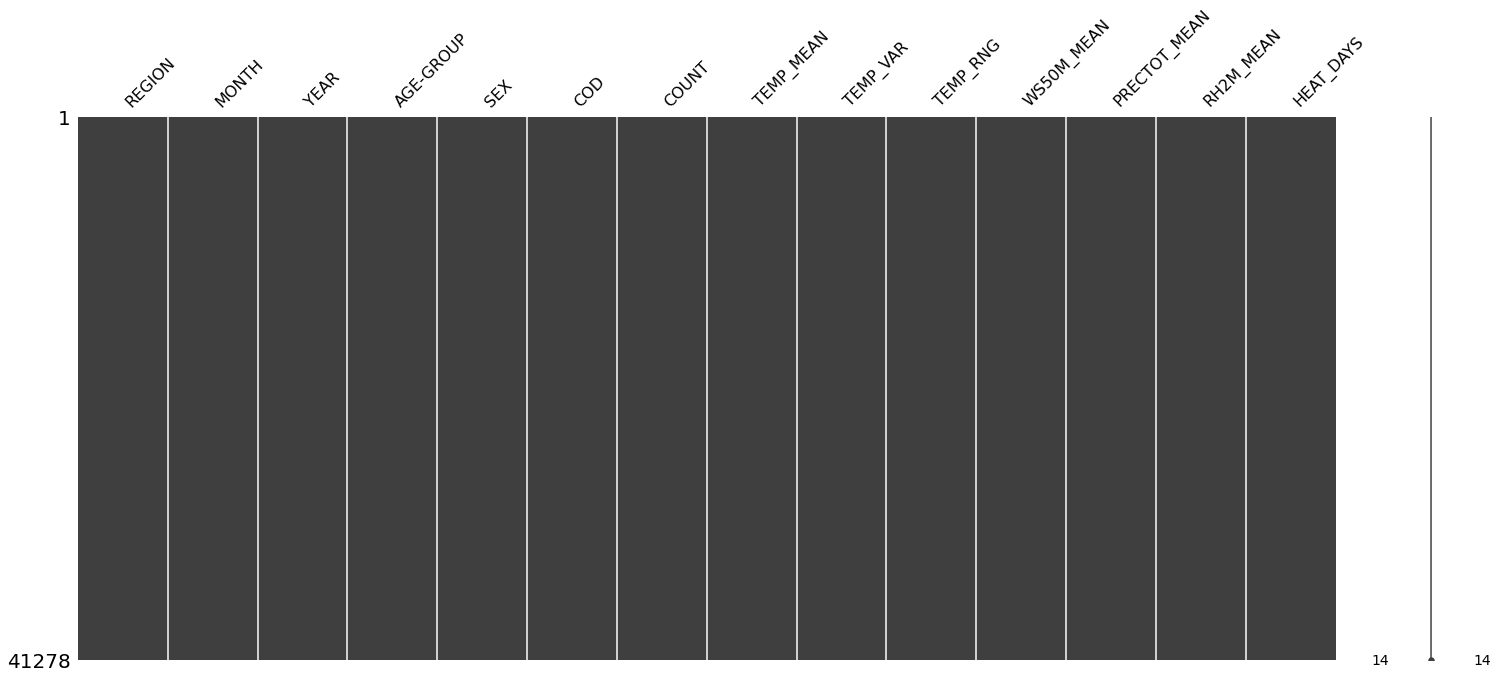

In [3]:
# Check for missing values, it seems alright
missingno.matrix(mortality)

In [4]:
# Summer period, comment it out if you want to do for the whole period
def get_summer(df):
    return df[(df['MONTH'] <= 8) & (df['MONTH'] >= 5)]
mortality = get_summer(mortality)

In [5]:
# Train-test split
TEST_SIZE = 0.1
SEED = 467051528
X_train, X_test, y_train, y_test = train_test_split(mortality.drop('COUNT', axis = 1), 
                                                    mortality['COUNT'], 
                                                    test_size = TEST_SIZE,
                                                    random_state = SEED,
                                                    shuffle = True)

In [6]:
# Preprocessing steps
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler())
])
categorical_transformer = OneHotEncoder(drop = 'first')

categorical_features = ['REGION', 'AGE-GROUP', 'SEX', 'COD']
numeric_features = X_train.columns.to_list()[6:]

preprocessor = ColumnTransformer(
    transformers = [
        ('drop_columns', 'drop', ['YEAR', 'MONTH']),
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [11]:
# Parameter grids
learning_rate = np.arange(0.01,.03, 0.01)
max_iter = np.arange(100, 1000, 100)
max_leaf_nodes = np.arange(10, 50, 5)
max_depth = np.arange(2, 10, 1)
l2_regularization = np.arange(0, 4, 0.05)

params = {'preprocessing__num' : [StandardScaler(), RobustScaler()], 
         'regressor__loss': ['least_squares', 'least_absolute_deviation', 'poisson'], 
         'regressor__learning_rate': learning_rate, 
         'regressor__max_iter': max_iter,
         'regressor__max_leaf_nodes': max_leaf_nodes,
         'regressor__max_depth': max_depth,
         'regressor__l2_regularization': l2_regularization}

In [28]:
# Model
model = Pipeline(steps = [
    ('preprocessing', preprocessor),
    ('dense_transform', FunctionTransformer(lambda x: x.todense(), accept_sparse = True)),
    ('regressor', HistGradientBoostingRegressor(categorical_features = np.arange(8, 28)))
])

In [29]:
# Grid search
search = RandomizedSearchCV(model, 
                            param_distributions = params, 
                            random_state = SEED)
search.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('drop_columns',
                                                                               'drop',
                                                                               ['YEAR',
                                                                                'MONTH']),
                                                                              ('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['TEMP_MEAN',
                                                                                'TEMP_VAR',
                                                                                'T

In [30]:
# Summary of grid search
pd.DataFrame(search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__max_leaf_nodes,param_regressor__max_iter,param_regressor__max_depth,param_regressor__loss,param_regressor__learning_rate,param_regressor__l2_regularization,param_preprocessing__num,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.940044,0.009653,0.011881,0.007856,25,100,7,least_squares,0.01,3.5,RobustScaler(),"{'regressor__max_leaf_nodes': 25, 'regressor__...",0.742201,0.747776,0.722555,0.722979,0.760656,0.739233,0.014718,8
1,1.953362,0.014295,0.026303,0.006401,25,500,4,least_squares,0.01,3.25,StandardScaler(),"{'regressor__max_leaf_nodes': 25, 'regressor__...",0.865542,0.873450,0.850951,0.850505,0.884884,0.865066,0.013225,6
2,1.614424,0.050386,0.022882,0.007076,20,400,4,poisson,0.01,2.55,StandardScaler(),"{'regressor__max_leaf_nodes': 20, 'regressor__...",0.871125,0.878853,0.855888,0.858403,0.883737,0.869601,0.010966,5
3,2.948922,0.082768,0.027009,0.006090,25,300,9,poisson,0.02,0.4,StandardScaler(),"{'regressor__max_leaf_nodes': 25, 'regressor__...",0.971965,0.973869,0.969688,0.974632,0.975537,0.973138,0.002088,2
4,1.794611,0.008830,0.019530,0.008195,15,300,9,poisson,0.01,2.55,RobustScaler(),"{'regressor__max_leaf_nodes': 15, 'regressor__...",0.914185,0.916557,0.904902,0.909503,0.925367,0.914103,0.006910,4
5,4.535321,0.077118,0.039299,0.006562,20,700,6,poisson,0.02,2.6,RobustScaler(),"{'regressor__max_leaf_nodes': 20, 'regressor__...",0.976934,0.978211,0.972083,0.977312,0.977137,0.976335,0.002170,1
6,6.089875,0.062383,0.044208,0.009181,20,700,8,least_absolute_deviation,0.01,3,RobustScaler(),"{'regressor__max_leaf_nodes': 20, 'regressor__...",0.865501,0.884546,0.870496,0.834717,0.852165,0.861485,0.016926,7
7,0.945559,0.026400,0.013802,0.003648,20,100,9,least_absolute_deviation,0.02,3.35,StandardScaler(),"{'regressor__max_leaf_nodes': 20, 'regressor__...",0.550780,0.508014,0.584576,0.481053,0.535163,0.531917,0.035490,10
8,1.048534,0.048191,0.042559,0.006400,10,900,2,least_squares,0.02,2.2,StandardScaler(),"{'regressor__max_leaf_nodes': 10, 'regressor__...",0.654145,0.648177,0.646556,0.631602,0.661133,0.648323,0.009805,9
9,2.467996,0.032028,0.043800,0.010275,10,800,4,least_squares,0.02,1.55,RobustScaler(),"{'regressor__max_leaf_nodes': 10, 'regressor__...",0.920570,0.922551,0.913807,0.913629,0.935244,0.921160,0.007892,3


In [31]:
# Best fitted scores
print(search.best_params_)
print('Best scores: ', search.best_score_)

{'regressor__max_leaf_nodes': 20, 'regressor__max_iter': 700, 'regressor__max_depth': 6, 'regressor__loss': 'poisson', 'regressor__learning_rate': 0.02, 'regressor__l2_regularization': 2.6, 'preprocessing__num': RobustScaler()}
Best scores:  0.9763354278603142


In [32]:
# Test performance
model_chosen = search.best_estimator_
y_pred = model_chosen.predict(X_test)

In [33]:
# Test loss
mean_squared_error(y_pred, y_test)

45.968387289594396

In [34]:
# Training loss
mean_squared_error(y_train, model_chosen.predict(X_train))

37.106991013121345

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


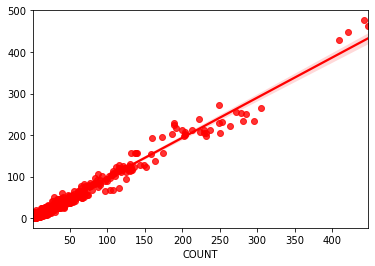

In [37]:
# Test data: y_test, y_pred
sns.regplot(y_test, y_pred, color = 'red')

In [38]:
# R-squared between y_pred and y_test
np.corrcoef(y_test, y_pred)

array([[1.        , 0.98946274],
       [0.98946274, 1.        ]])

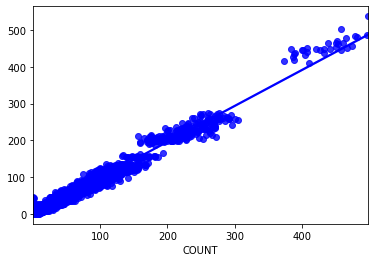

In [39]:
# Training data: y_test, y_pred_train
y_pred_train = model_chosen.predict(X_train)
sns.regplot(x = y_train, y = y_pred_train, color = 'blue')

In [40]:
# R-squared between y_pred and y_pred_train
np.corrcoef(y_train, y_pred_train)

array([[1.        , 0.99043417],
       [0.99043417, 1.        ]])

In [56]:
# Save the model
with open('gradientboosting.pkl', 'wb') as file:
    dill.dump(model_chosen, file) 